<a href="https://colab.research.google.com/github/Aelamin19/Business-Analytics/blob/main/FYP_2021_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor

In [56]:
rent_df = pd.read_csv("/content/avg monthly rent 2008-2022.csv")
d_i_df = pd.read_csv("/content/Disposable income 2021.csv")
h_p_df = pd.read_csv("/content/House purchases.csv")
crime_df = pd.read_csv('/content/recorded_crime_ireland.csv')

#Data preprocessing - Rent df

In [57]:
rent_df

,STATISTIC Label,Year,Number of Bedrooms,Property Type,Location,UNIT,VALUE
0,RTB Average Monthly Rent Report,2008,One bed,Detached house,Carlow,Euro,NaN
1,RTB Average Monthly Rent Report,2008,One bed,Detached house,Carlow Town,Euro,NaN
2,RTB Average Monthly Rent Report,2008,One bed,Detached house,"Graiguecullen, Carlow",Euro,NaN
3,RTB Average Monthly Rent Report,2008,One bed,Detached house,"Tullow, Carlow",Euro,NaN
4,RTB Average Monthly Rent Report,2008,One bed,Detached house,Cavan,Euro,NaN
...,...,...,...,...,...,...,...
200695,RTB Average Monthly Rent Report,2022,Four plus bed,Other flats,"Delgany, Wicklow",Euro,NaN
200696,RTB Average Monthly Rent Report,2022,Four plus bed,Other flats,"Greystones, Wicklow",Euro,NaN
200697,RTB Average Monthly Rent Report,2022,Four plus bed,Other flats,"Kilcoole, Wicklow",Euro,NaN
200698,RTB Average Monthly Rent Report,2022,Four plus bed,Other flats,"Newtownmountkennedy, Wicklow",Euro,NaN


In [58]:
#The 'All properties' value is not needed, so it will be removed
rent_df = rent_df.drop(rent_df[rent_df['Property Type'] == 'All property types'].index)

In [59]:
#Now, unnecessary columns will be removed
rent_df = rent_df.drop("STATISTIC Label", axis = "columns")
rent_df = rent_df.drop("UNIT", axis = "columns")

In [60]:
#The rows with null values will be removed
rent_df.dropna(subset=["VALUE"], inplace=True)

##creating a "regions" column

In [61]:
#try with * if not working
def get_region(county, region):
    if county in region["Dublin"]:
        return 'Dublin'
    if county in region["Border"]:
        return 'Border'
    elif county in region["West"]:
        return 'West'
    elif county in region["Mid_West"]:
        return 'Mid_West'
    elif county in region["Mid_East"]:
        return 'Mid_East'
    elif county in region["South_East"]:
        return 'South_East'
    elif county in region["South_West"]:
        return 'South_West'
    elif county in region["Midland"]:
        return "Midland"
    else:
        return None

In [62]:
Dublin = ["Dublin", "Dún Laoghaire-Rathdown", "South-Dublin", "Fingal"]
Border = ["Cavan", "Donegal", "Leitrim", "Monaghan", "Sligo"]
West = ["Mayo", "Roscommon", "Galway"]
Mid_West = ["Clare", "Tipperary", "Limerick"]
Mid_East = ["Kildare", "Louth", "Meath", "Wicklow"]
South_East = ["Carlow", "Kilkenny", "Wexford", "Waterford"]
South_West = ["Kerry", "Cork"]
Midland = ["Laois", "Longford", "Offaly", "Westmeath"]

In [63]:
region = {"Dublin": Dublin, "Border": Border, "West": West, "Mid_West": Mid_West, "Mid_East": Mid_East, "South_East": South_East, "South_West": South_West, "Midland": Midland}
rent_df['region'] = rent_df["Location"].apply(get_region, args=(region,))
rent_df.head(10)

,Year,Number of Bedrooms,Property Type,Location,VALUE,region
20,2008,One bed,Detached house,Cork,556.54,South_West
71,2008,One bed,Detached house,Dublin,1031.97,Dublin
238,2008,One bed,Detached house,Galway,518.02,West
466,2008,One bed,Semi detached house,Cork,624.69,South_West
467,2008,One bed,Semi detached house,Cork City,680.40,None
517,2008,One bed,Semi detached house,Dublin,855.05,Dublin
561,2008,One bed,Semi detached house,Dublin 3,745.08,None
570,2008,One bed,Semi detached house,Dublin 4,911.54,None
582,2008,One bed,Semi detached house,Dublin 6,801.92,None
594,2008,One bed,Semi detached house,Dublin 7,642.81,None


In [64]:
rent_df['region'].unique()

array(['South_West', 'Dublin', 'West', None, 'Mid_East', 'Mid_West',
       'South_East', 'Border', 'Midland'], dtype=object)

In [65]:
rent_df.rename(columns = {"VALUE": "rent_value"},
          inplace = True)

In [66]:
#The columns with counties will now be removed because the regions are much better to work with
rent_df = rent_df.drop("Location", axis = "columns")

##Changing categorical columns to become useful

In [67]:
rent_df = rent_df.drop(rent_df[rent_df['Number of Bedrooms'] == '1 to 2 bed'].index)
rent_df = rent_df.drop(rent_df[rent_df['Number of Bedrooms'] == '1 to 3 bed'].index)
#Lets now assign weights for the number of bedrooms
rent_df["Number of Bedrooms"] = rent_df["Number of Bedrooms"].map({"Four plus bed": 4,
                                                                   "Three bed": 3,
                                                                   "Two bed": 2,
                                                                   "One bed": 1})

In [68]:
#rent_df = rent_df.join(pd.get_dummies(rent_df["Number of Bedrooms"])).drop(["Number of Bedrooms"], axis=1)
rent_df = rent_df.join(pd.get_dummies(rent_df["Property Type"])).drop(["Property Type"], axis=1)

In [69]:
rent_df = rent_df.replace({True: 1, False: 0})

#Data Preprocessing - Disposable Income

In [70]:
#Now, unnecessary columns will be removed
d_i_df = d_i_df.drop("Statistic Label", axis = "columns")
d_i_df = d_i_df.drop("UNIT", axis = "columns")

In [71]:
d_i_df.rename(columns = {"VALUE": "avg_disposable_income"},
          inplace = True)

In [72]:
d_i_df.rename(columns = {'NUTS 3 Region':'region'}, inplace = True)

In [73]:
d_i_df

,Year,region,avg_disposable_income
0,2021,Border,8450.09
1,2021,Midland,6699.88
2,2021,West,10783.13
3,2021,Dublin,39684.85
4,2021,Mid-East,17434.03
5,2021,Mid-West,11853.13
6,2021,South-East,9980.96
7,2021,South-West,17448.48


In [74]:
d_i_df['region'].replace('Mid-East', 'Mid_East', inplace=True)
d_i_df['region'].replace('Mid-West', 'Mid_West', inplace=True)
d_i_df['region'].replace('South-East', 'South_East', inplace=True)
d_i_df['region'].replace('South-West', 'South_West', inplace=True)

#Data Preprocessing - House Purchases

In [75]:
h_p_df = h_p_df.drop("Statistic Label", axis = "columns")
h_p_df = h_p_df.drop("UNIT", axis = "columns")

In [76]:
#removing the letters from the month column to make it a year column
h_p_df['Month'] = h_p_df['Month'].str.replace('\D', '', regex=True)

In [77]:
h_p_df.rename(columns = {"Month": "Year"},
          inplace = True)

In [78]:
h_p_df.rename(columns = {"VALUE": "house_purchase_price"},
          inplace = True)

In [79]:
h_p_df.rename(columns = {"RPPI Region": "County"},
          inplace = True)

In [80]:
h_p_df['Year'] = h_p_df['Year'].astype('int')

##creating a "regions" column

In [81]:
#The dataset has counties as well as regions
#The regions will be removed because the counties differ from my created regions
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'Border Excluding Louth'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'South-East excluding South Tipperary'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'West'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'Mid-East including Louth'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'Mid-West including South Tipperary'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'South-East excluding South Tipperary'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'South-West'].index)
h_p_df = h_p_df.drop(h_p_df[h_p_df['County'] == 'Midland'].index)

In [82]:
h_p_df["County"] = h_p_df["County"].str.replace(' City', '')
h_p_df["County"] = h_p_df["County"].str.replace(' County', '')

In [83]:
region = {"Dublin": Dublin, "Border": Border, "West": West, "Mid_West": Mid_West, "Mid_East": Mid_East, "South_East": South_East, "South_West": South_West, "Midland": Midland}
h_p_df['region'] = h_p_df["County"].apply(get_region, args=(region,))
h_p_df.head(10)

,Year,Type of Dwelling,Dwelling Status,Stamp Duty Event,County,house_purchase_price,region
1,2010,Apartment,New,Filings,Cavan,NaN,Border
2,2010,Apartment,New,Filings,Donegal,NaN,Border
3,2010,Apartment,New,Filings,Leitrim,NaN,Border
4,2010,Apartment,New,Filings,Monaghan,NaN,Border
5,2010,Apartment,New,Filings,Sligo,170250.0,Border
7,2010,Apartment,New,Filings,Laois,199995.0,Midland
8,2010,Apartment,New,Filings,Longford,NaN,Midland
9,2010,Apartment,New,Filings,Offaly,NaN,Midland
10,2010,Apartment,New,Filings,Westmeath,256061.0,Midland
12,2010,Apartment,New,Filings,Galway,490000.0,West


In [84]:
h_p_df['region'].unique()

array(['Border', 'Midland', 'West', 'Dublin', None, 'Mid_East',
       'Mid_West', 'South_East', 'South_West'], dtype=object)

In [85]:
#The columns with counties will now be removed because the regions are much better to work with
h_p_df = h_p_df.drop("County", axis = "columns")

In [86]:
#The rows with null values will be removed
h_p_df.dropna(subset=["house_purchase_price"], inplace=True)
h_p_df.dropna(subset=["region"], inplace=True)

#Data Preprocessing - Crime df

In [87]:
year = []
for i in crime_df['Quarter']:
  year.append(i[:4])

In [88]:
crime_df['Year'] = year

In [89]:
crime_df.rename(columns = {'VALUE':'Number_of_Crimes'}, inplace = True)

##creating a "regions" column

In [90]:
Dublin = ["D.M.R. South Central Garda Division", "D.M.R. North Central Garda Division", "D.M.R. Northern Garda Division", "D.M.R. Southern Garda Division", "D.M.R. Eastern Garda Division", "D.M.R. Western Garda Division"]
Border = ["Cavan/Monaghan Garda Division", "Donegal Garda Division", "Sligo/Leitrim Garda Division"]
West = ["Mayo Garda Division", "Roscommon/Longford Garda Division", "Galway Garda Division"]
Mid_West = ["Clare Garda Division", "Tipperary Garda Division", "Limerick Garda Division"]
Mid_East = ["Kildare Garda Division", "Louth Garda Division", "Meath Garda Division", "Wicklow Garda Division"]
South_East = ["Kilkenny/Carlow Garda Division", "Wexford Garda Division", "Waterford Garda Division"]
South_West = ["Kerry Garda Division", "Cork City Garda Division", "Cork West Garda Division"]
Midland = ["Laois/Offaly Garda Division", "Westmeath Garda Division"]

In [91]:
region = {"Dublin": Dublin, "Border": Border, "West": West, "Mid_West": Mid_West, "Mid_East": Mid_East, "South_East": South_East, "South_West": South_West, "Midland": Midland}
crime_df['region'] = crime_df["Garda Division"].apply(get_region, args=(region,))

##Adding all crimes of each type for each region

In [92]:
crime_df_2 = crime_df.groupby(["Type of Offence", "Year", "region"])["Number_of_Crimes"].sum().reset_index()

**Crimes of lower severity are removed**

In [93]:
crime_df_2 = crime_df_2.drop(crime_df_2[crime_df_2['Type of Offence'] == 'Litter offences'].index)
crime_df_2 = crime_df_2.drop(crime_df_2[crime_df_2['Type of Offence'] == 'False alarm/interference with aircraft or air transport facilities'].index)
crime_df_2 = crime_df_2.drop(crime_df_2[crime_df_2['Type of Offence'] == 'Disorderly conduct'].index)

In [94]:
crime_df_2 = crime_df_2.drop(['Type of Offence'], axis=1)

#Merging the dataframes into 1 dataframe

##Data preprocessing - combined df

In [95]:
cb_df = pd.merge(rent_df, d_i_df, on= ['Year', "region"])
cb_df = pd.merge(cb_df, h_p_df, on= ['Year', "region"])

In [96]:
crime_df_2 = crime_df.groupby(["Year", "region"])["Number_of_Crimes"].sum().reset_index()

In [97]:
cb_df['Year'].dtypes

dtype('int64')

In [98]:
crime_df_2['Year'].dtypes

dtype('O')

In [99]:
crime_df_2["Year"] = crime_df_2["Year"].astype(int)

In [100]:
cb_df = cb_df.drop("Type of Dwelling", axis = "columns")
cb_df = cb_df.drop("Dwelling Status", axis = "columns")
cb_df = cb_df.drop("Stamp Duty Event", axis = "columns")

###Sample of the dataset taken

The full combined dataset is too large to be combined with the crime dataset (not enough RAM in my device) so a sample will be taken

In [101]:
#The merged dataset is too large, so a sample is taken
cb_sample_df = cb_df.sample(frac=0.4)

In [102]:
cb_sample_df = cb_sample_df.sort_values('Year')

In [103]:
cb_sample_df = pd.merge(cb_sample_df, crime_df_2, on= ['Year', "region"])

In [104]:
cb_sample_df

,Year,Number of Bedrooms,rent_value,region,Apartment,Detached house,Other flats,Semi detached house,Terrace house,avg_disposable_income,house_purchase_price,Number_of_Crimes
0,2021,1,932.03,Mid_East,0,1,0,0,0,17434.03,219472.0,42748
1,2021,4,1704.17,Mid_East,0,0,0,0,1,17434.03,471960.0,42748
2,2021,4,1767.75,Mid_East,0,1,0,0,0,17434.03,355421.0,42748
3,2021,1,914.85,Mid_East,1,0,0,0,0,17434.03,448342.0,42748
4,2021,2,1216.72,Mid_East,0,1,0,0,0,17434.03,198811.0,42748
...,...,...,...,...,...,...,...,...,...,...,...,...
43347,2021,2,1201.37,South_West,1,0,0,0,0,17448.48,485000.0,33177
43348,2021,3,1404.15,South_West,1,0,0,0,0,17448.48,113500.0,33177
43349,2021,2,1133.53,South_West,0,0,0,0,1,17448.48,250386.0,33177
43350,2021,2,850.61,South_West,1,0,0,0,0,17448.48,502709.0,33177


In [105]:
cb_sample_df['region'].unique()

array(['Mid_East', 'Mid_West', 'Border', 'Dublin', 'Midland', 'West',
       'South_East', 'South_West'], dtype=object)

In [106]:
cb_sample_df = cb_sample_df.join(pd.get_dummies(cb_sample_df["region"])).drop(["region"], axis=1)

In [107]:
X_cb1_2021 = cb_sample_df.drop(["house_purchase_price"], axis=1)
#The house purchase price is set as the target variable
y_cb1_2021 = cb_sample_df['house_purchase_price']

In [108]:
import pickle
loaded_XGB_house_price_model = pickle.load(open('/content/xgb_house_price.pkl', 'rb'))

In [109]:
X_cb1_2021

,Year,Number of Bedrooms,rent_value,Apartment,Detached house,Other flats,Semi detached house,Terrace house,avg_disposable_income,Number_of_Crimes,Border,Dublin,Mid_East,Mid_West,Midland,South_East,South_West,West
0,2021,1,932.03,0,1,0,0,0,17434.03,42748,False,False,True,False,False,False,False,False
1,2021,4,1704.17,0,0,0,0,1,17434.03,42748,False,False,True,False,False,False,False,False
2,2021,4,1767.75,0,1,0,0,0,17434.03,42748,False,False,True,False,False,False,False,False
3,2021,1,914.85,1,0,0,0,0,17434.03,42748,False,False,True,False,False,False,False,False
4,2021,2,1216.72,0,1,0,0,0,17434.03,42748,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43347,2021,2,1201.37,1,0,0,0,0,17448.48,33177,False,False,False,False,False,False,True,False
43348,2021,3,1404.15,1,0,0,0,0,17448.48,33177,False,False,False,False,False,False,True,False
43349,2021,2,1133.53,0,0,0,0,1,17448.48,33177,False,False,False,False,False,False,True,False
43350,2021,2,850.61,1,0,0,0,0,17448.48,33177,False,False,False,False,False,False,True,False


In [110]:
pred_house_price_2021 = loaded_XGB_house_price_model.predict(X_cb1_2021)

In [111]:
pred_house_price_2021[:20]

array([314739.28, 321089.66, 306500.78, 318032.62, 312777.7 , 313810.1 ,
       309514.9 , 317095.25, 315175.3 , 319256.66, 317095.25, 315714.53,
       306500.78, 317095.25, 313707.22, 316024.34, 319453.1 , 319669.8 ,
       316024.34, 313138.7 ], dtype=float32)

In [112]:
X_cb2_2021 = cb_sample_df.drop(["rent_value"], axis=1)
#The house purchase price is set as the target variable
y_cb2_2021 = cb_sample_df['rent_value']

In [113]:
#X_train_cb2_2021, X_test_cb2_2021, y_train_cb2_2021, y_test_cb2_2021 = train_test_split(X_cb2_2021,y_cb2_2021, test_size= 0.2)

In [114]:
#reg_xgb2 = xgb.XGBRegressor(n_estimators= 1000, early_stopping_rounds= 50) #stops early if no improvment after 50 trees
#reg_xgb2.fit(X_train_cb2_2021, y_train_cb2_2021,
#           eval_set=[(X_train_cb2_2021, y_train_cb2_2021), (X_test_cb2_2021, y_test_cb2_2021)],
#           verbose=10)

In [115]:
#reg_xgb2.score(X_test_cb2_2021, y_test_cb2_2021)

In [116]:
#import pickle
#filename = 'xgb_rent_price.pkl'
#pickle.dump(reg_xgb2, open(filename, 'wb'))

In [117]:
import pickle
loaded_XGB_rent_price_model = pickle.load(open('/content/xgb_rent_price.pkl', 'rb'))

In [118]:
pred_rent_price_2021 = loaded_XGB_rent_price_model.predict(X_cb2_2021)

In [119]:
pred_rent_price_2021[:20]

array([ 937.4302 , 1538.8591 , 1621.2225 ,  991.18567, 1131.8856 ,
       1264.3203 , 1143.3479 , 1336.3184 , 1130.248  ,  777.4052 ,
       1432.3282 , 1531.0012 , 1621.2225 , 1334.1375 , 1311.2606 ,
       1444.7283 , 1432.3282 , 1130.248  , 1432.3282 , 1531.0012 ],
      dtype=float32)

#Dividing the df by region

In [120]:
Dublin_df = cb_sample_df.loc[cb_sample_df['Dublin']==1]
South_East_df = cb_sample_df.loc[cb_sample_df['South_East']==1]
South_west_df = cb_sample_df.loc[cb_sample_df['South_West']==1]
West_df = cb_sample_df.loc[cb_sample_df['West']==1]
Midland_df = cb_sample_df.loc[cb_sample_df['Midland']==1]
Mid_East_df = cb_sample_df.loc[cb_sample_df['Mid_East']==1]
Mid_West_df = cb_sample_df.loc[cb_sample_df['Mid_West']==1]
Border_df = cb_sample_df.loc[cb_sample_df['Border']==1]


In [121]:
#Dublin_df

#Predicting values for Dublin df

In [122]:
X_Dub_HP = Dublin_df.drop(["house_purchase_price"], axis=1)
#The house purchase price is set as the target variable
y_Dub_HP = Dublin_df['house_purchase_price']

In [123]:
X_Dub_R = Dublin_df.drop(["rent_value"], axis=1)
#The rent price is set as the target variable
y_Dub_R = Dublin_df['rent_value']

In [124]:
pred_Dub_HP = loaded_XGB_house_price_model.predict(X_Dub_HP)

In [125]:
pred_Dub_R = loaded_XGB_rent_price_model.predict(X_Dub_R)

In [126]:
loaded_XGB_house_price_model.score(X_Dub_HP, y_Dub_HP)

-0.00523079300302931

In [127]:
loaded_XGB_rent_price_model.score(X_Dub_R, y_Dub_R)

0.9994881860415596

In [128]:
pred_Dub_HP[:20]

array([559569.7 , 549729.9 , 540932.6 , 543759.2 , 586810.  , 517665.38,
       530558.7 , 517665.38, 548925.25, 556201.44, 549018.94, 586810.  ,
       542145.2 , 542145.2 , 581606.6 , 559569.7 , 575964.3 , 539061.7 ,
       552512.4 , 517665.38], dtype=float32)

In [129]:
pred_Dub_R[:20]

array([2125.5012, 1322.4833, 1918.148 , 1847.989 , 2250.4734, 1408.8883,
       1700.3173, 1408.8883, 1080.3907, 2660.6401, 1943.6824, 2250.4734,
       1757.3323, 1757.3323, 2390.6194, 2125.5012, 1726.563 , 3027.5188,
       1974.0393, 1408.8883], dtype=float32)

In [130]:
#Find the average (mean) of a list
def Average(list):
  return sum(list) / len(list)

In [131]:
#Find the median of a list
def Median(list):
  list.sort()
  mid = len(list) // 2
  res = (list[mid] + list[~mid]) / 2
  return res

In [132]:
pred_average_HP_Dub = Average(pred_Dub_HP)
pred_average_HP_Dub

pred_median_HP_Dub = Median(pred_Dub_HP)
pred_median_HP_Dub

548925.25

In [133]:
pred_average_R_Dub = Average(pred_Dub_R)
pred_average_R_Dub

pred_median_R_Dub = Median(pred_Dub_R)
pred_median_R_Dub

1918.14794921875

#Predicting values for South East df

In [134]:
X_SE_HP = South_East_df.drop(["house_purchase_price"], axis=1)
#The house purchase price is set as the target variable
y_SE_HP = South_East_df['house_purchase_price']

In [135]:
X_SE_R = South_East_df.drop(["rent_value"], axis=1)
#The rent price is set as the target variable
y_SE_R = South_East_df['rent_value']

In [136]:
pred_SE_HP = loaded_XGB_house_price_model.predict(X_SE_HP)

In [137]:
pred_SE_R = loaded_XGB_rent_price_model.predict(X_SE_R)

In [138]:
loaded_XGB_house_price_model.score(X_SE_HP, y_SE_HP)

-0.0003181166108732203

In [139]:
loaded_XGB_rent_price_model.score(X_SE_R, y_SE_R)

0.8810136808901418

In [140]:
pred_average_HP_SE = Average(pred_SE_HP)
pred_average_HP_SE

pred_median_HP_SE = Median(pred_SE_HP)
pred_median_HP_SE

224642.421875

In [141]:
pred_average_R_SE = Average(pred_SE_R)
pred_average_R_SE

pred_median_R_SE = Median(pred_SE_R)
pred_median_R_SE

862.7412109375

#Predicting values for South West df

In [142]:
X_SW_HP = South_west_df.drop(["house_purchase_price"], axis=1)
#The house purchase price is set as the target variable
y_SW_HP = South_west_df['house_purchase_price']

In [143]:
X_SW_R = South_west_df.drop(["rent_value"], axis=1)
#The rent price is set as the target variable
y_SW_R = South_west_df['rent_value']

In [144]:
pred_SW_HP = loaded_XGB_house_price_model.predict(X_SW_HP)

In [145]:
pred_SW_R = loaded_XGB_rent_price_model.predict(X_SW_R)

In [146]:
loaded_XGB_house_price_model.score(X_SW_HP, y_SW_HP)

-0.003571644141919572

In [147]:
loaded_XGB_rent_price_model.score(X_SW_R, y_SW_R)

0.6656179232554786

In [148]:
pred_average_HP_SW = Average(pred_SW_HP)
pred_average_HP_SW

pred_median_HP_SW = Median(pred_SW_HP)
pred_median_HP_SW

287130.9375

In [149]:
pred_average_R_SW = Average(pred_SW_R)
pred_average_R_SW

pred_median_R_SW = Median(pred_SW_R)
pred_median_R_SW

935.8778076171875

#Predicting values for West DF

In [150]:
X_W_HP = West_df.drop(["house_purchase_price"], axis=1)
#The house purchase price is set as the target variable
y_W_HP = West_df['house_purchase_price']

In [151]:
X_W_R = West_df.drop(["rent_value"], axis=1)
#The rent price is set as the target variable
y_W_R = West_df['rent_value']

In [152]:
pred_W_HP = loaded_XGB_house_price_model.predict(X_W_HP)

In [153]:
pred_W_R = loaded_XGB_rent_price_model.predict(X_W_R)

In [154]:
loaded_XGB_house_price_model.score(X_W_HP, y_W_HP)

-0.0006555916445374343

In [155]:
loaded_XGB_rent_price_model.score(X_W_R, y_W_R)

0.4719472445504629

In [156]:
pred_average_HP_W = Average(pred_W_HP)
pred_average_HP_W

pred_median_HP_W = Median(pred_W_HP)
pred_median_HP_W

233663.53125

In [157]:
pred_average_R_W = Average(pred_W_R)
pred_average_R_W

pred_median_R_W = Median(pred_W_R)
pred_median_R_W

819.357666015625

#Predicting values for Midland df

In [158]:
X_M_HP = Midland_df.drop(["house_purchase_price"], axis=1)
#The house purchase price is set as the target variable
y_M_HP = Midland_df['house_purchase_price']

In [159]:
X_M_R = Midland_df.drop(["rent_value"], axis=1)
#The rent price is set as the target variable
y_M_R = Midland_df['rent_value']

In [160]:
pred_M_HP = loaded_XGB_house_price_model.predict(X_M_HP)

In [161]:
pred_M_R = loaded_XGB_rent_price_model.predict(X_M_R)

In [162]:
loaded_XGB_house_price_model.score(X_M_HP, y_M_HP)

-0.0025012820130476676

In [163]:
loaded_XGB_rent_price_model.score(X_M_R, y_M_R)

0.6401658137325756

In [164]:
pred_average_HP_M = Average(pred_M_HP)
pred_average_HP_M

pred_median_HP_M = Median(pred_M_HP)
pred_median_HP_M

193774.125

In [165]:
pred_average_R_M = Average(pred_M_R)
pred_average_R_M

pred_median_R_M = Median(pred_M_R)
pred_median_R_M

852.0408325195312

#Predicting values for Mid East DF

In [166]:
X_ME_HP = Mid_East_df.drop(["house_purchase_price"], axis=1)
#The house purchase price is set as the target variable
y_ME_HP = Mid_East_df['house_purchase_price']

In [167]:
X_ME_R = Mid_East_df.drop(["rent_value"], axis=1)
#The rent price is set as the target variable
y_ME_R = Mid_East_df['rent_value']

In [168]:
pred_ME_HP = loaded_XGB_house_price_model.predict(X_ME_HP)

In [169]:
pred_ME_R = loaded_XGB_rent_price_model.predict(X_ME_R)

In [170]:
loaded_XGB_house_price_model.score(X_ME_HP, y_ME_HP)

-0.0037708390944337644

In [171]:
loaded_XGB_rent_price_model.score(X_ME_R, y_ME_R)

0.7856295881321147

In [172]:
pred_average_HP_ME = Average(pred_ME_HP)
pred_average_HP_ME

pred_median_HP_ME = Median(pred_ME_HP)
pred_median_HP_ME

316024.34375

In [173]:
pred_average_R_ME = Average(pred_ME_R)
pred_average_R_ME

pred_median_R_ME = Median(pred_ME_R)
pred_median_R_ME

1263.6187744140625

#Predicting values for Mid West DF

In [174]:
X_MW_HP = Mid_West_df.drop(["house_purchase_price"], axis=1)
#The house purchase price is set as the target variable
y_MW_HP = Mid_West_df['house_purchase_price']

In [175]:
X_MW_R = Mid_West_df.drop(["rent_value"], axis=1)
#The rent price is set as the target variable
y_MW_R = Mid_West_df['rent_value']

In [176]:
pred_MW_HP = loaded_XGB_house_price_model.predict(X_MW_HP)

In [177]:
pred_MW_R = loaded_XGB_rent_price_model.predict(X_MW_R)

In [178]:
loaded_XGB_house_price_model.score(X_MW_HP, y_MW_HP)

-0.0015413555662595613

In [179]:
loaded_XGB_rent_price_model.score(X_MW_R, y_MW_R)

0.6113910155720579

In [180]:
pred_average_HP_MW = Average(pred_MW_HP)
pred_average_HP_MW

pred_median_HP_MW = Median(pred_MW_HP)
pred_median_HP_MW

210562.09375

In [181]:
pred_average_R_MW = Average(pred_MW_R)
pred_average_R_MW

pred_median_R_MW = Median(pred_MW_R)
pred_median_R_MW

842.0819091796875

#Predicting values for Border DF

In [182]:
X_B_HP = Border_df.drop(["house_purchase_price"], axis=1)
#The house purchase price is set as the target variable
y_B_HP = Border_df['house_purchase_price']

In [183]:
X_B_R = Border_df.drop(["rent_value"], axis=1)
#The rent price is set as the target variable
y_B_R = Border_df['rent_value']

In [184]:
pred_B_HP = loaded_XGB_house_price_model.predict(X_B_HP)

In [185]:
pred_B_R = loaded_XGB_rent_price_model.predict(X_B_R)

In [186]:
loaded_XGB_house_price_model.score(X_B_HP, y_B_HP)

-0.007044263260213457

In [187]:
loaded_XGB_rent_price_model.score(X_B_R, y_B_R)

0.6880967530613975

In [188]:
pred_average_HP_B = Average(pred_B_HP)
pred_average_HP_B

pred_median_HP_B = Median(pred_B_HP)
pred_median_HP_B

160388.890625

In [189]:
pred_average_R_B = Average(pred_B_R)
pred_average_R_B

pred_median_R_B = Median(pred_B_R)
pred_median_R_B

670.8225708007812

#Creating tables to display the predicted average house/rent values for all region

In [190]:
Avg_pred_values = {'Region': ['Dublin', 'South_East', 'South_West', 'West', 'Midland', 'Mid_East', 'Mid_West', 'Border'],
              'Avg House Price': [pred_average_HP_Dub, pred_average_HP_SE, pred_average_HP_SW, pred_average_HP_W, pred_average_HP_M, pred_average_HP_ME, pred_average_HP_MW, pred_average_HP_B],
              'Avg Rent Price': [pred_average_R_Dub, pred_average_R_SE, pred_average_R_SW, pred_average_R_W, pred_average_R_M, pred_average_R_ME, pred_average_R_MW, pred_average_R_B],
              'Median House price': [pred_median_HP_Dub, pred_median_HP_SE, pred_median_HP_SW, pred_median_HP_W, pred_median_HP_M, pred_median_HP_ME, pred_median_HP_MW, pred_median_HP_B],
              'Median rent price': [pred_median_R_Dub, pred_median_R_SE, pred_median_R_SW, pred_median_R_W, pred_median_R_M, pred_median_R_ME, pred_median_R_MW, pred_median_R_B]}

In [191]:
Avg_pred_val_DF = pd.DataFrame.from_dict(Avg_pred_values)
Avg_pred_val_DF

,Region,Avg House Price,Avg Rent Price,Median House price,Median rent price
0,Dublin,551656.846873,1918.609489,548925.250000,1918.147949
1,South_East,224001.098883,886.221007,224642.421875,862.741211
2,South_West,286536.602447,1003.666540,287130.937500,935.877808
3,West,232531.007921,873.950688,233663.531250,819.357666
4,Midland,193825.318408,835.661637,193774.125000,852.040833
5,Mid_East,315168.871338,1244.445697,316024.343750,1263.618774
6,Mid_West,210896.539357,861.164479,210562.093750,842.081909
7,Border,160669.367460,670.434221,160388.890625,670.822571


In [192]:
cb_sample_df

,Year,Number of Bedrooms,rent_value,Apartment,Detached house,Other flats,Semi detached house,Terrace house,avg_disposable_income,house_purchase_price,Number_of_Crimes,Border,Dublin,Mid_East,Mid_West,Midland,South_East,South_West,West
0,2021,1,932.03,0,1,0,0,0,17434.03,219472.0,42748,False,False,True,False,False,False,False,False
1,2021,4,1704.17,0,0,0,0,1,17434.03,471960.0,42748,False,False,True,False,False,False,False,False
2,2021,4,1767.75,0,1,0,0,0,17434.03,355421.0,42748,False,False,True,False,False,False,False,False
3,2021,1,914.85,1,0,0,0,0,17434.03,448342.0,42748,False,False,True,False,False,False,False,False
4,2021,2,1216.72,0,1,0,0,0,17434.03,198811.0,42748,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43347,2021,2,1201.37,1,0,0,0,0,17448.48,485000.0,33177,False,False,False,False,False,False,True,False
43348,2021,3,1404.15,1,0,0,0,0,17448.48,113500.0,33177,False,False,False,False,False,False,True,False
43349,2021,2,1133.53,0,0,0,0,1,17448.48,250386.0,33177,False,False,False,False,False,False,True,False
43350,2021,2,850.61,1,0,0,0,0,17448.48,502709.0,33177,False,False,False,False,False,False,True,False


##calculating the averages of the actual values

In [193]:
Dub_house_prices = Dublin_df['house_purchase_price']
Dub_rent_prices = Dublin_df['rent_value']


In [194]:
Dub_rent_prices

20066    2136.98
20067    1322.19
20068    1925.37
20069    1858.88
20070    2265.29
          ...   
23163    2265.29
23164    2398.66
23165    1925.37
23166    1322.19
23167    1078.87
Name: rent_value, Length: 3102, dtype: float64

In [195]:
average_HP_Dub = Average(Dub_house_prices)
average_R_Dub = Average(Dub_rent_prices)

median_HP_Dub = Median(Dub_house_prices.tolist())
median_R_Dub = Median(Dub_rent_prices.tolist())

In [196]:
SE_house_prices = South_East_df['house_purchase_price']
SE_rent_prices = South_East_df['rent_value']

In [197]:
average_HP_SE = Average(SE_house_prices)
average_R_SE = Average(SE_rent_prices)

median_HP_SE = Median(SE_house_prices.tolist())
median_R_SE = Median(SE_rent_prices.tolist())

In [198]:
SW_house_prices = South_west_df['house_purchase_price']
SW_rent_prices = South_west_df['rent_value']

In [199]:
average_HP_SW = Average(SW_house_prices)
average_R_SW = Average(SW_rent_prices)

median_HP_SW = Median(SW_house_prices.tolist())
median_R_SW = Median(SW_rent_prices.tolist())

In [200]:
W_house_prices = West_df['house_purchase_price']
W_rent_prices = West_df['rent_value']

In [201]:
average_HP_W = Average(W_house_prices)
average_R_W = Average(W_rent_prices)

median_HP_W = Median(W_house_prices.tolist())
median_R_W = Median(W_rent_prices.tolist())

In [202]:
M_house_prices = Midland_df['house_purchase_price']
M_rent_prices = Midland_df['rent_value']

In [203]:
average_HP_M = Average(M_house_prices)
average_R_M = Average(M_rent_prices)

median_HP_M = Median(M_house_prices.tolist())
median_R_M = Median(M_rent_prices.tolist())

In [204]:
ME_house_prices = Mid_East_df['house_purchase_price']
ME_rent_prices = Mid_East_df['rent_value']

In [205]:
average_HP_ME = Average(ME_house_prices)
average_R_ME = Average(ME_rent_prices)

median_HP_ME = Median(ME_house_prices.tolist())
median_R_ME = Median(ME_rent_prices.tolist())

In [206]:
MW_house_prices = Mid_West_df['house_purchase_price']
MW_rent_prices = Mid_West_df['rent_value']

In [207]:
average_HP_MW = Average(MW_house_prices)
average_R_MW = Average(MW_rent_prices)

median_HP_MW = Median(MW_house_prices.tolist())
median_R_MW = Median(MW_rent_prices.tolist())

In [208]:
B_house_prices = Border_df['house_purchase_price']
B_rent_prices = Border_df['rent_value']

In [209]:
average_HP_B = Average(B_house_prices)
average_R_B = Average(B_rent_prices)

median_HP_B = Median(B_house_prices.tolist())
median_R_B = Median(B_rent_prices.tolist())

##calculating values for ROI calculation - Dublin

In [210]:
Dub_rent_total_2016_to_2020 = 102872.64
Dub_purchase_price_2016 = 401540.43

In [211]:
Dub_purchase_price_2021 = Average(Dublin_df['house_purchase_price'])

Dub_avg_rent_2021 = Average(Dublin_df['rent_value'])

In [212]:
Dub_rent_total_2016_to_2021 = Dub_rent_total_2016_to_2020 + Dub_avg_rent_2021

In [213]:
Dub_ROI = (Dub_rent_total_2016_to_2021 + Dub_purchase_price_2021 - Dub_purchase_price_2016) / Dub_purchase_price_2016

In [214]:
Dub_ROI

0.6590294841865044

##calculating values for ROI calculation - South East

In [215]:
SE_rent_total_2016_to_2020 = 44245.220272406616
SE_purchase_price_2016 = 152112.25336597307

In [216]:
SE_purchase_price_2021 = Average(South_East_df['house_purchase_price'])

SE_avg_rent_2021 = Average(South_East_df['rent_value'])

In [217]:
SE_rent_total_2016_to_2021 = SE_rent_total_2016_to_2020 + SE_avg_rent_2021

In [218]:
SE_ROI = (SE_rent_total_2016_to_2021 + SE_purchase_price_2021 - SE_purchase_price_2016) / SE_purchase_price_2016

In [219]:
SE_ROI

0.7745086498090252

##calculating values for ROI calculation - South West

In [220]:
SW_rent_total_2016_to_2020 = 49086.96596310081
SW_purchase_price_2016 = 196364.09

In [221]:
SW_purchase_price_2021 = Average(South_west_df['house_purchase_price'])

SW_avg_rent_2021 = Average(South_west_df['rent_value'])

In [222]:
SW_rent_total_2016_to_2021 = SW_rent_total_2016_to_2020 + SW_avg_rent_2021

In [223]:
SW_ROI = (SW_rent_total_2016_to_2021 + SW_purchase_price_2021 - SW_purchase_price_2016) / SW_purchase_price_2016

In [224]:
SW_ROI

0.7169329179102525

##calculating values for ROI calculation - West

In [225]:
W_rent_total_2016_to_2020 = 43510.09184654853
W_purchase_price_2016 = 142578.45635910225

In [226]:
W_purchase_price_2021 = Average(West_df['house_purchase_price'])

W_avg_rent_2021 = Average(West_df['rent_value'])

In [227]:
W_rent_total_2016_to_2021 = W_rent_total_2016_to_2020 + W_avg_rent_2021

In [228]:
W_ROI = (W_rent_total_2016_to_2021 + W_purchase_price_2021 - W_purchase_price_2016) / W_purchase_price_2016

In [229]:
W_ROI

0.9469086786752959

##calculating values for ROI calculation - Midland

In [230]:
M_rent_total_2016_to_2020 = 41085.698267321
M_purchase_price_2016 = 115475.1993006993

In [231]:
M_purchase_price_2021 = Average(Midland_df['house_purchase_price'])

M_avg_rent_2021 = Average(Midland_df['rent_value'])

In [232]:
M_rent_total_2016_to_2021 = M_rent_total_2016_to_2020 + M_avg_rent_2021

In [233]:
M_ROI = (M_rent_total_2016_to_2021 + M_purchase_price_2021 - M_purchase_price_2016) / M_purchase_price_2016

In [234]:
M_ROI

1.0140861096828166

##calculating values for ROI calculation - Mid East

In [235]:
ME_rent_total_2016_to_2020 = 62415.22103008344
ME_purchase_price_2016 = 228611.41341463415

In [236]:
ME_purchase_price_2021 = Average(Mid_East_df['house_purchase_price'])

ME_avg_rent_2021 = Average(Mid_East_df['rent_value'])

In [237]:
ME_rent_total_2016_to_2021 = ME_rent_total_2016_to_2020 + ME_avg_rent_2021

In [238]:
ME_ROI = (ME_rent_total_2016_to_2021 + ME_purchase_price_2021 - ME_purchase_price_2016) / ME_purchase_price_2016

In [239]:
ME_ROI

0.6704633076761507

##calculating values for ROI calculation - Mid West

In [240]:
MW_rent_total_2016_to_2020 = 42715.73155905846
MW_purchase_price_2016 = 228611.41341463415

In [241]:
MW_purchase_price_2021 = Average(Mid_West_df['house_purchase_price'])

MW_avg_rent_2021 = Average(Mid_West_df['rent_value'])

In [242]:
MW_rent_total_2016_to_2021 = MW_rent_total_2016_to_2020 + MW_avg_rent_2021

In [243]:
MW_ROI = (MW_rent_total_2016_to_2021 + MW_purchase_price_2021 - MW_purchase_price_2016) / MW_purchase_price_2016

In [244]:
MW_ROI

0.10722002865138958

##calculating values for ROI calculation - Border

In [245]:
B_rent_total_2016_to_2020 = 34375.09392053289
B_purchase_price_2016 = 112483.06155398587

In [246]:
B_purchase_price_2021 = Average(Border_df['house_purchase_price'])

B_avg_rent_2021 = Average(Border_df['rent_value'])

In [247]:
B_rent_total_2016_to_2021 = B_rent_total_2016_to_2020 + B_avg_rent_2021

In [248]:
B_ROI = (B_rent_total_2016_to_2021 + B_purchase_price_2021 - B_purchase_price_2016) / B_purchase_price_2016

In [249]:
B_ROI

0.7035687189156242

#Creating tables to display the actual average house/rent values for all region

In [250]:
Actual_values = {'Region': ['Dublin', 'South_East', 'South_West', 'West', 'Midland', 'Mid_East', 'Mid_West', 'Border'],
              'Avg House Price': [average_HP_Dub, average_HP_SE, average_HP_SW, average_HP_W, average_HP_M, average_HP_ME, average_HP_MW, average_HP_B],
              'Avg Rent Price': [average_R_Dub, average_R_SE, average_R_SW, average_R_W, average_R_M, average_R_ME, average_R_MW, average_R_B],
              'Median House price': [median_HP_Dub, median_HP_SE, median_HP_SW, median_HP_W, median_HP_M, median_HP_ME, median_HP_MW, median_HP_B],
              'Median rent price': [median_R_Dub, median_R_SE, median_R_SW, median_R_W, median_R_M, median_R_ME, median_R_MW, median_R_B]}

In [251]:
Act_Val_DF = pd.DataFrame.from_dict(Actual_values)
Act_Val_DF

,Region,Avg House Price,Avg Rent Price,Median House price,Median rent price
0,Dublin,561366.592843,1928.179620,520799.0,1925.37
1,South_East,224794.935716,884.353351,229000.0,861.02
2,South_West,287053.346732,1003.657321,270000.0,942.58
3,West,233205.620340,871.521891,225593.0,763.42
4,Midland,190657.344572,833.952085,190372.0,846.61
5,Mid_East,318223.011568,1248.745227,313277.0,1216.72
6,Mid_West,209552.391610,855.012542,207217.0,806.46
7,Border,156581.242537,666.288613,154733.0,659.85


#Comparing predicted values to actual values

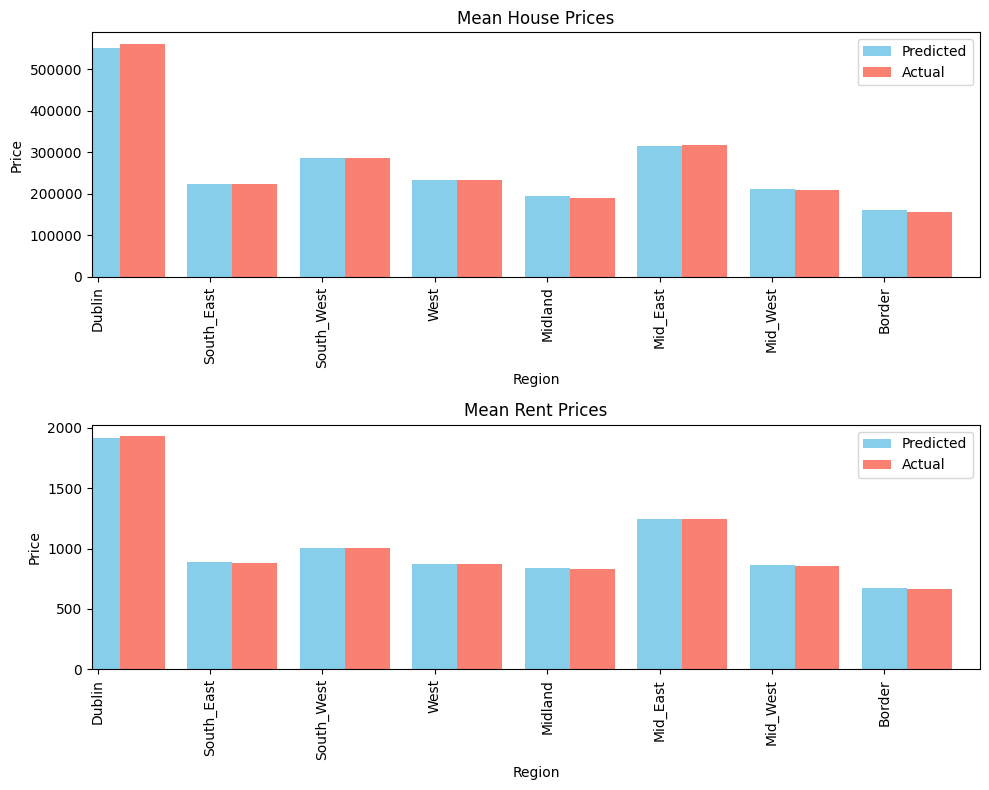

In [256]:
# Set region as index
#Avg_pred_val_DF.set_index('Region', inplace=True)
#Act_Val_DF.set_index('Region', inplace=True)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plotting mean of House Prices
Avg_pred_val_DF['Avg House Price'].plot(kind='bar', ax=axes[0], color='skyblue', position=0.5, width=0.4, label='Predicted')
Act_Val_DF['Avg House Price'].plot(kind='bar', ax=axes[0], color='salmon', position=-0.5, width=0.4, label='Actual')

axes[0].set_title('Mean House Prices')
axes[0].set_ylabel('Price')
axes[0].legend()

# Plotting mean of Rent Prices
Avg_pred_val_DF['Avg Rent Price'].plot(kind='bar', ax=axes[1], color='skyblue', position=0.5, width=0.4, label='Predicted')
Act_Val_DF['Avg Rent Price'].plot(kind='bar', ax=axes[1], color='salmon', position=-0.5, width=0.4, label='Actual')

axes[1].set_title('Mean Rent Prices')
axes[1].set_ylabel('Price')
axes[1].legend()

plt.tight_layout()
plt.show()

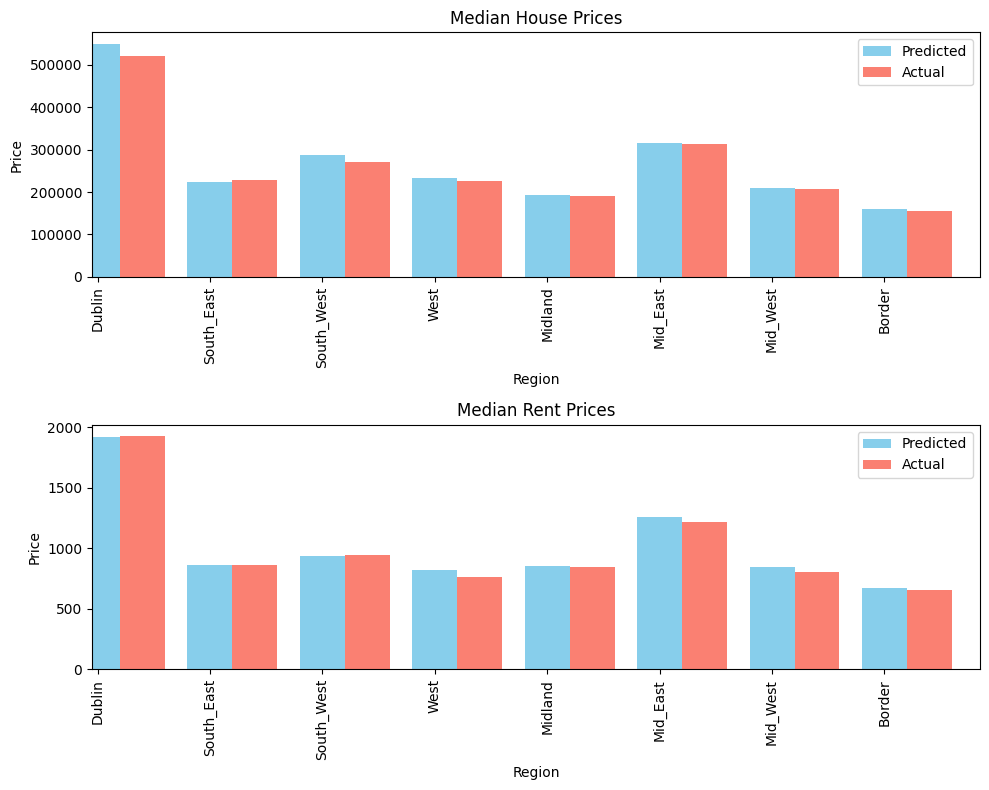

In [257]:
# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plotting Median House Prices
Avg_pred_val_DF['Median House price'].plot(kind='bar', ax=axes[0], color='skyblue', position=0.5, width=0.4, label='Predicted')
Act_Val_DF['Median House price'].plot(kind='bar', ax=axes[0], color='salmon', position=-0.5, width=0.4, label='Actual')

axes[0].set_title('Median House Prices')
axes[0].set_ylabel('Price')
axes[0].legend()

# Plotting Median Rent Prices
Avg_pred_val_DF['Median rent price'].plot(kind='bar', ax=axes[1], color='skyblue', position=0.5, width=0.4, label='Predicted')
Act_Val_DF['Median rent price'].plot(kind='bar', ax=axes[1], color='salmon', position=-0.5, width=0.4, label='Actual')

axes[1].set_title('Median Rent Prices')
axes[1].set_ylabel('Price')
axes[1].legend()

plt.tight_layout()
plt.show()

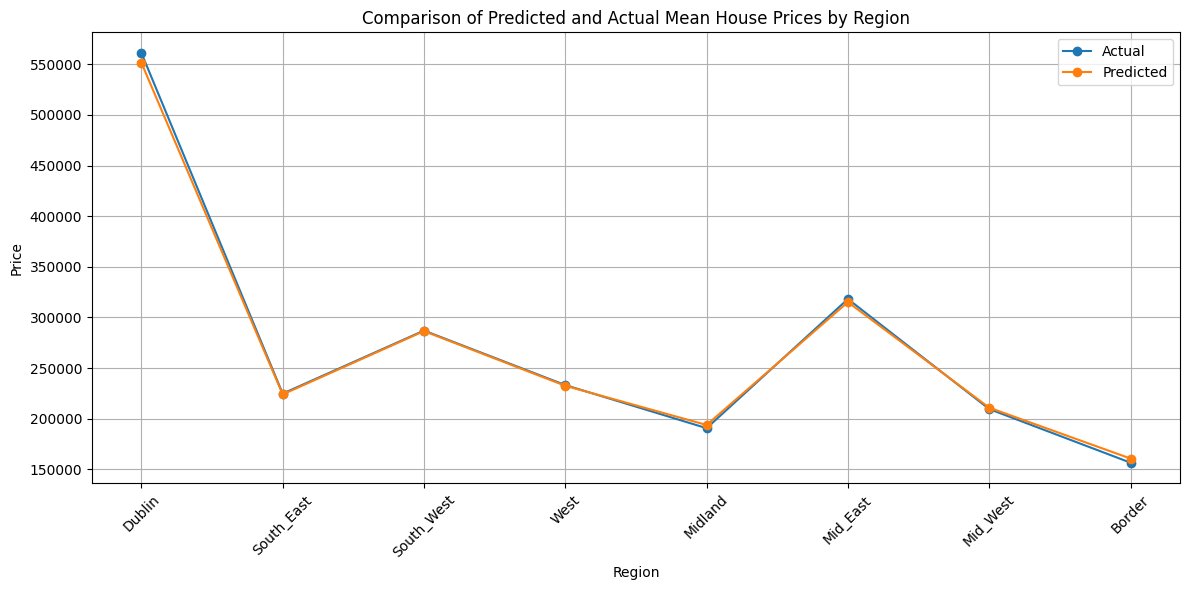

In [260]:
# Plot for mean values
plt.figure(figsize=(12, 6))
Act_Val_DF['Avg House Price'].plot(label='Actual', marker='o')
Avg_pred_val_DF['Avg House Price'].plot(label='Predicted', marker='o')
plt.title('Comparison of Predicted and Actual Mean House Prices by Region')
plt.xlabel('Region')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

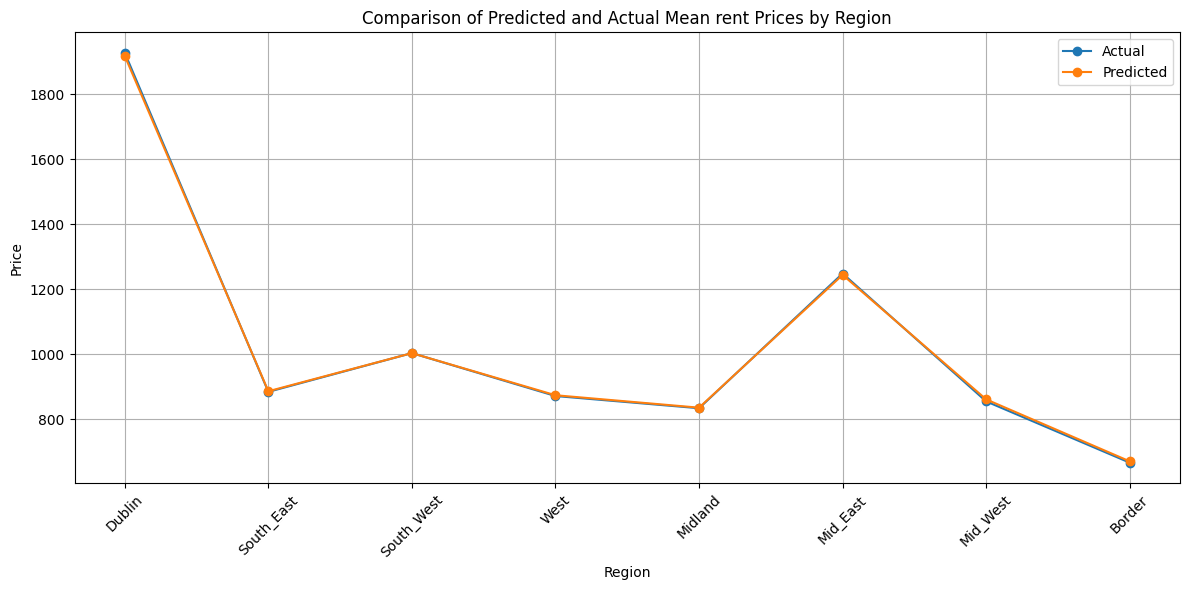

In [262]:
# Plot for mean values
plt.figure(figsize=(12, 6))
Act_Val_DF['Avg Rent Price'].plot(label='Actual', marker='o')
Avg_pred_val_DF['Avg Rent Price'].plot(label='Predicted', marker='o')
plt.title('Comparison of Predicted and Actual Mean rent Prices by Region')
plt.xlabel('Region')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

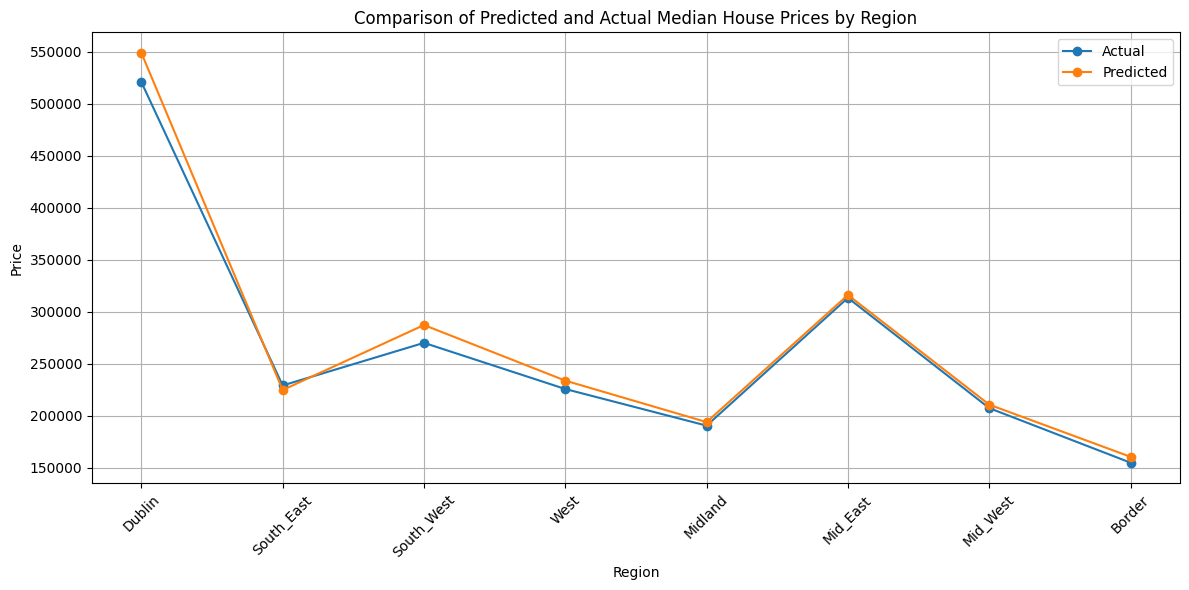

In [261]:
# Plot for median values
plt.figure(figsize=(12, 6))
Act_Val_DF['Median House price'].plot(label='Actual', marker='o')
Avg_pred_val_DF['Median House price'].plot(label='Predicted', marker='o')
plt.title('Comparison of Predicted and Actual Median House Prices by Region')
plt.xlabel('Region')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

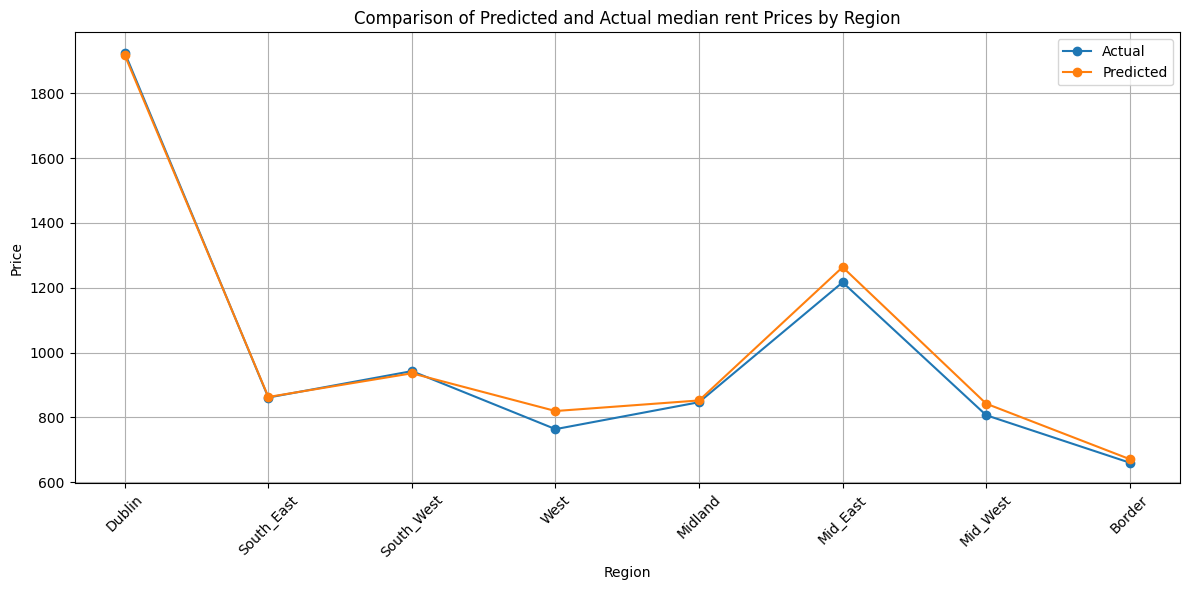

In [264]:
plt.figure(figsize=(12, 6))
Act_Val_DF['Median rent price'].plot(label='Actual', marker='o')
Avg_pred_val_DF['Median rent price'].plot(label='Predicted', marker='o')
plt.title('Comparison of Predicted and Actual median rent Prices by Region')
plt.xlabel('Region')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Displaying the ROI for all regions

In [258]:
ROI = {'Region': ['Dublin', 'South East', 'South West', 'West', 'Midland', 'Mid East', 'Mid West', 'Border'],
       'ROI': [Dub_ROI, SE_ROI, SW_ROI, W_ROI, M_ROI, ME_ROI, MW_ROI, B_ROI]}

In [259]:
pd.DataFrame.from_dict(ROI).sort_values('ROI', ascending = False)

,Region,ROI
4,Midland,1.014086
3,West,0.946909
1,South East,0.774509
2,South West,0.716933
7,Border,0.703569
5,Mid East,0.670463
0,Dublin,0.659029
6,Mid West,0.107220
